In [1]:
import numpy as np
import pandas as pd
import copy
pd.set_option('display.notebook_repr_html', False)
from matplotlib import pyplot as plt
from scipy import signal
from IPython.display import Markdown
from IPython.core.debugger import set_trace as breakpt

# Day 20: Jurassic Jigsaw

Reference: https://adventofcode.com/2020/day/20

## Part 1

**What do you get if you multiply together the IDs of the four corner tiles?**

In [2]:
trdict = {'.': '0', '#': '1'}
puzpiece = list()
puzdict = dict()
with open('puzzle_input.txt', 'r') as fid:
    for line in fid:
        if not line.strip():
            # Empty line. Flush the data
            puzdict[tileid] = puzpiece
            puzpiece = list()
            continue
        if line.startswith('Tile'):
            tileid = int(line.split()[1][:-1])
            continue
        # Assume line is puzzle piece data
        puzpiece.append(''.join([trdict[x] for x in line.strip()]))
        

In [3]:
# Convert string puzzle pieces to numpy arrays
puzdict2 = dict()
for k, v in puzdict.items():
    puzdict2[k] = np.array([[int(x) for x in r] for r in v], dtype=np.uint8)

In [4]:
def get_int(arr):
    # Return the decimal integer for the
    # supplied 1-D arr of 0's & 1's
    return int(''.join([str(x) for x in arr]), 2)

def get_edges(arr):
    # Treat array edges as binary number and
    # get all possible values for each edges
    # read forwards and backwards (accounts for
    # possible rotations and flips)
    edgelist = list()
    edgelist.append(get_int(arr[0]))
    edgelist.append(get_int(arr[0][::-1]))
    edgelist.append(get_int(arr[-1]))
    edgelist.append(get_int(arr[-1][::-1]))
    edgelist.append(get_int(arr[:, 0]))
    edgelist.append(get_int(arr[:, 0][::-1]))
    edgelist.append(get_int(arr[:, -1]))
    edgelist.append(get_int(arr[:, -1][::-1]))
    return edgelist

In [5]:
# Get all possible edge values for puzzle pieces
puzedges = {k: get_edges(v) for k, v in puzdict2.items()}
df = pd.DataFrame(puzedges)
df

   1409  2939  3347  1297  3203  1283  1879  2293  3079  1069  ...  3217  \
0   810    11   101   603   980   968  1012   733   736   352  ...   228   
1   339   832   664   873   175    79   191   749    29    26  ...   156   
2   710  1017  1021    91   721   743   634   319   686   692  ...    69   
3   397   639   767   872   557   925   377  1010   469   181  ...   648   
4   977   361   115   930   987   913   525   660   531   151  ...   102   
5   559   602   824   279   879   551   705   165   801   932  ...   408   
6   148   767   529   881   229   357   316   821    28    64  ...   457   
7   164  1021   545   571   668   666   242   691   224     8  ...   590   

   1861  3593  3041  2647  2437  3709  2039  3011  1151  
0   990   439   925   751   392  1019   882   104   421  
1   495   950   743   989    70   895   315    88   662  
2   768   129   483   673   713   177   981   526   660  
3     3   516   798   533   589   564   687   449   165  
4   655   100   628   881

In [6]:
# Any puzzle piece with 2 unique edges is a corner piece
# With flip and rotation then we would expect 4 unique
# edges for a corner piece
corners = dict()
for colnum in df:
    colvals = set(df[colnum])
    othervals = set(df.drop(colnum, axis=1).values.ravel())
    nmissing = len(colvals - othervals)
    if nmissing > 3:
        # Must be a corner piece
        corners[colnum] = colvals - othervals
        
corners

{3607: {62, 281, 496, 610},
 1697: {167, 371, 826, 916},
 2731: {68, 136, 294, 402},
 1399: {123, 321, 522, 888}}

In [ ]:
mx = 1
for k in corners.keys():
    mx *= k

In [1]:
#Markdown("The product of the 4 corner pieces is **{}**".format(mx))

## Part Two

**How many # are not part of a sea monster?**

In [8]:
# Looks like I really do have to perform the assembly.
# Make a class to hold all the necessary data and methods...
class PuzzPieces(object):
    """
    Data structure for holding puzzle pieces
    and provide convenient methods for accessing
    and assembling them.
    """
    def __init__(self, puzdict):
        """
        Parameters
        ----------
        puzdict: dict
            Dictionary of key ids for the puzzle pieces
            and values of 2D numpy array of 0's & 1's
            representing each piece
        """
        self._puzdict = puzdict
        # Get all possible edge values for puzzle pieces
        puzedges = {k: self.get_edges(v) for k, v in puzdict.items()}
        self._puzedges = pd.DataFrame(puzedges)
        self._edgeids = dict()
        self._build_edgelookup()
        # Create a set of unused pieces from which to choose when constructing
        self.unused = set(self.puzdict.keys())
        # Array to hold the puzzle assembly ids
        self.assembly = np.zeros((12, 12), dtype=np.uint16)
        # Lists to hold array pieces rotated into place
        self.list_assembly = list()
        # PUZZLE PIECES ASSEMBLE!
        self.list_of_rows = list()
        self.assemble()
        
    def sub_assemble(self, r, c, pcarr, side='bottom'):
        """
        Find and place the piece for r, c that will match
        the supplied piece-array along piece-array's side
        """
        if 'bottom' == side:
            edgefn = self.get_bottom_edgeid
            match_to_side = 'top'
        elif 'right' == side:
            edgefn = self.get_right_edgeid
            match_to_side = 'left'
        else:
            raise ValueError("Unhandled side: {}".format(side))

        # Find matching piece for pcid
        edgeid = edgefn(pcarr)
        id1 = self.find_match(edgeid)
        pc1 = self.get_arr(id1)
        
        # Assign it to the assembly
        self.assembly[r][c] = id1
        # Drop it from unused
        self.unused.discard(id1)
        # Now transform as necessary so the edges will mesh
        pc1 = self.tx_to_fit(pc1, edgefn(pcarr), side=match_to_side)
        # Return the transformed array
        return pc1
    
    def assemble(self):
        """
        Assemble the puzzle. From earlier we've already identified
        the corner pieces. Prime the array with a known corner
        piece and work to fill it out from there
        """
        row_list = list()
        id0 = 3607
        
        # Assign it to the assembly
        self.assembly[0][0] = id0
        # Drop it from unused
        self.unused.discard(id0)
        # Get the piece array
        pc0 = self.get_arr(id0)
        # Add it to the row_list
        row_list.append(pc0)

        # Construct the first row
        ii = np.ndindex((1, 12))
        # Throw out (0, 0) since we've manually placed it already
        next(ii)
        for r, c in ii:
            #print("Row: {} Col: {}".format(r, c))
            pcarr = row_list[-1]
            pc1 = self.sub_assemble(r, c, pcarr, 'right')
            row_list.append(pc1)
            
        self.list_of_rows.append(row_list)
        row_list = list()
        # With the first row constructed we can now iterate
        # over all the rest of the puzzle locations matching
        # pieces to the piece above
        ii = np.ndindex((12, 12))
        rprev = 1 # Help identify when a new row is started
        for r, c in ii:
            if 0 == r:
                # Already populated first row. Nothing to do
                continue
            if r > rprev:
                # Commit the row_list to list_of_rows and flush
                self.list_of_rows.append(row_list)
                row_list = list()
                rprev = r
            # Fit the next piece
            pcarr = self.list_of_rows[-1][c]
            pc1 = self.sub_assemble(r, c, pcarr, 'bottom')
            row_list.append(pc1)               
        # Don't forget to append the last row
        self.list_of_rows.append(row_list)
        
    def tx_to_fit(self, arr, edgeid, side='top'):
        """
        Transform the supplied arr until the requested
        edgeid appears along side (top or left). Return
        the transformed array.
        """
        if 'top' == side:
            getfn = self.get_top_edgeid
        elif 'left' == side:
            getfn = self.get_left_edgeid
        arr1 = arr.copy()
        # First try rotating all around
        for _ in range(4):
            edgeid1 = getfn(arr1)
            if edgeid1 == edgeid:
                # MATCH
                return arr1
            arr1 = np.rot90(arr1)
        # Still here? didn't match, flip and rotate
        arr1 = np.fliplr(arr1)
        # Try rotating around again
        for _ in range(4):
            edgeid1 = getfn(arr1)
            if edgeid1 == edgeid:
                # MATCH
                return arr1
            arr1 = np.rot90(arr1)
        # Still here? Never found a match
        raise ValueError("No match found for {}".format(edgeid))
        
    def find_match(self, edgeid):
        """
        Use the supplied edgeid to find and return the
        puzzle piece id that matches it
        """
        match = self.edgeids[edgeid] & self.unused
        #print(edgeid, match)
        if 1 < len(match):
            raise ValueError("More than 1 match found")
        return next(iter(match))
        
    @staticmethod
    def get_int(arr):
        """
        Return the decimal integer for the
        supplied 1-D arr of 0's & 1's
        """
        return int(''.join([str(x) for x in arr]), 2)

    @staticmethod
    def get_top_edgeid(arr, flip=False):
        """
        From the supplied array, return the id for its
        top edge
        """
        if not flip:
            return get_int(arr[0])
        else:
            return get_int(arr[0][::-1])
        
    @staticmethod
    def get_bottom_edgeid(arr, flip=False):
        """
        From the supplied array, return the id for its
        bottom edge
        """
        if not flip:
            return get_int(arr[-1])
        else:
            return get_int(arr[-1][::-1])

    @staticmethod
    def get_right_edgeid(arr, flip=False):
        """
        From the supplied array, return the id for its
        right edge
        """
        if not flip:
            return get_int(arr[:, -1])
        else:
            return get_int(arr[:, -1][::-1])

    @staticmethod
    def get_left_edgeid(arr, flip=False):
        """
        From the supplied array, return the id for its
        left edge
        """
        if not flip:
            return get_int(arr[:, 0])
        else:
            return get_int(arr[:, 0][::-1])

    def get_edges(self, arr):
        """
        Treat array edges as binary number and
        get all possible values for each edges
        read forwards and backwards (accounts for
        possible rotations and flips)
        """
        edgelist = list()
        edgelist.append(self.get_top_edgeid(arr))
        edgelist.append(self.get_top_edgeid(arr, flip=True))
        edgelist.append(self.get_bottom_edgeid(arr))
        edgelist.append(self.get_bottom_edgeid(arr, flip=True))
        edgelist.append(self.get_left_edgeid(arr))
        edgelist.append(self.get_left_edgeid(arr, flip=True))
        edgelist.append(self.get_right_edgeid(arr))
        edgelist.append(self.get_right_edgeid(arr, flip=True))
        return edgelist
   
    @property
    def puzdict(self):
        """
        Dictionary keyed on puzzle id with values of
        2D numpy array of 0's and 1's
        """
        return self._puzdict
    
    def get_arr(self, pcid):
        """
        Return the 2D array for the supplied pcid
        """
        return self.puzdict[pcid]
    
    @property
    def puzedges(self):
        """
        DataFrame of puzzle piece ids with all possible associated
        edge ids
        """
        return self._puzedges
    
    def _build_edgelookup(self):
        """
        Create a reverse lookup on puzz edges so we can ask for
        any edge and get that piece id in retturn
        """
        for i, ser in self.puzedges.iteritems():
            for edge in ser:
                if edge in self._edgeids:
                    self._edgeids[edge].add(i)
                else:
                    self._edgeids[edge] = {i}
                
    @property
    def edgeids(self):
        """
        Dictionary of all possible edge ids for keys with
        all associated puzzle piece ids for values
        """
        return self._edgeids

In [9]:
puzpcs = PuzzPieces(copy.deepcopy(puzdict2))
# The puzzle is now assembled in a list of lists
# still including the border alignment data available
# in the puzpcs.list_of_rows attribute

In [10]:
# Make a function that will assemble the data list
# into a single numpy array highlighting the alignment
# frame borders
def make_arr(datalist):
    datcols = list()
    for datrow in datalist:
        datrow2 = list()
        for arr in datrow:
            arr[0][arr[0] == 1] = 2
            arr[-1][arr[-1] == 1] = 2
            arr[:,0][arr[:,0] == 1] = 2
            arr[:,-1][arr[:,-1] == 1] = 2
            datrow2.append(arr)
        datcols.append(np.concatenate(datrow2, axis=1))
    return np.concatenate(datcols, axis=0)

arr = make_arr(puzpcs.list_of_rows)

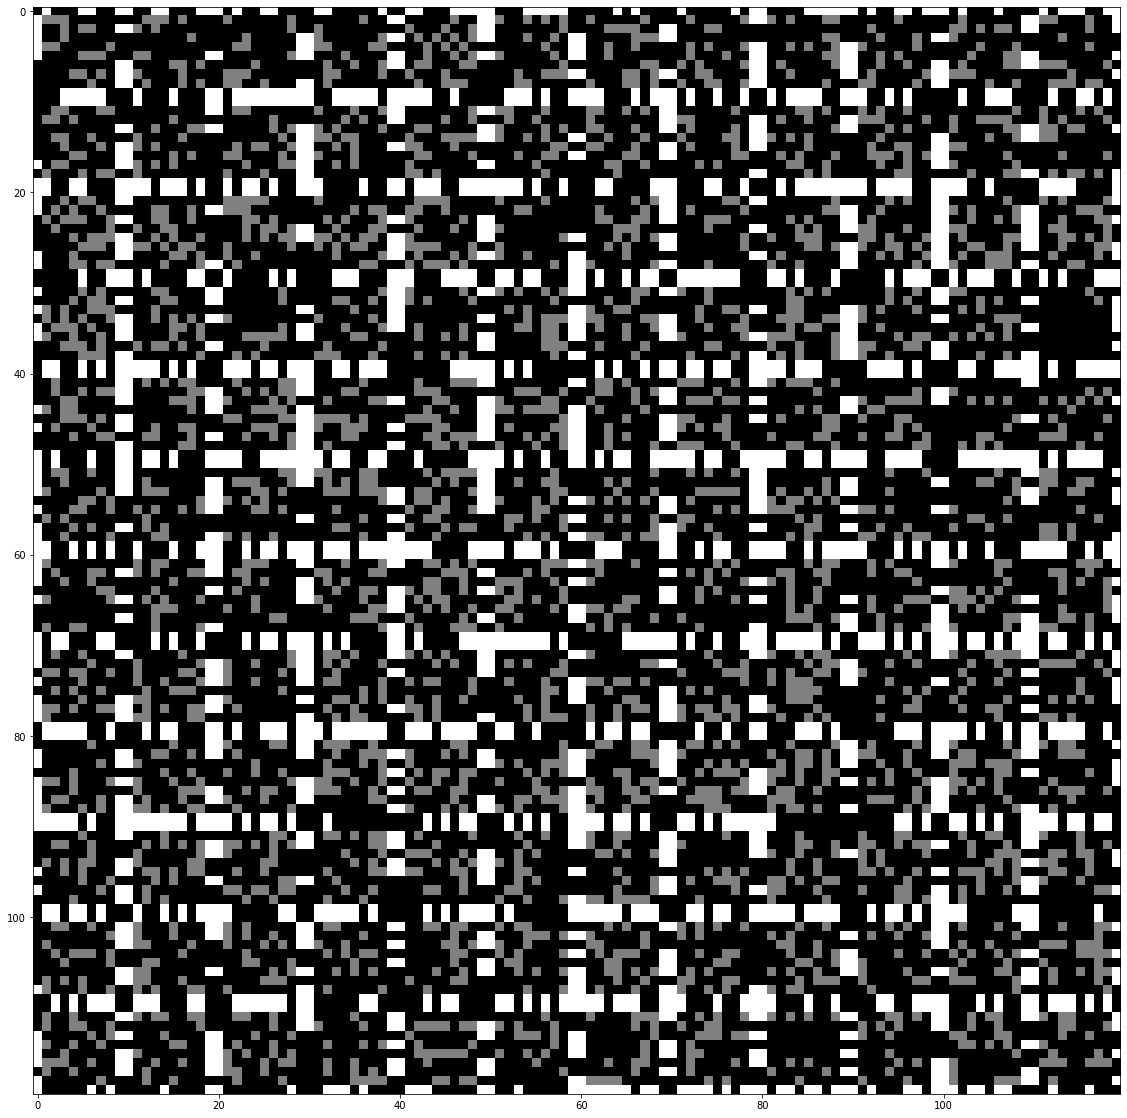

In [11]:
# Make a plot with boundaries. All vertical line boundaries
# should be "double wide" and all horizontal line boundaries
# should be "double tall". Anywhere this is not the case means
# something is wrong with the fit.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.imshow(arr, cmap='gray')

In [12]:
# Looks good. Now strip out the  alignment frames
def make_true_arr(datalist):
    datcols = list()
    for datrow in datalist:
        datrow2 = list()
        for arr in datrow:
            datrow2.append(arr[1:-1, 1:-1])
        datcols.append(np.concatenate(datrow2, axis=1))
    return np.concatenate(datcols, axis=0)

puzpcs = PuzzPieces(copy.deepcopy(puzdict2))
arr2 = make_true_arr(puzpcs.list_of_rows)

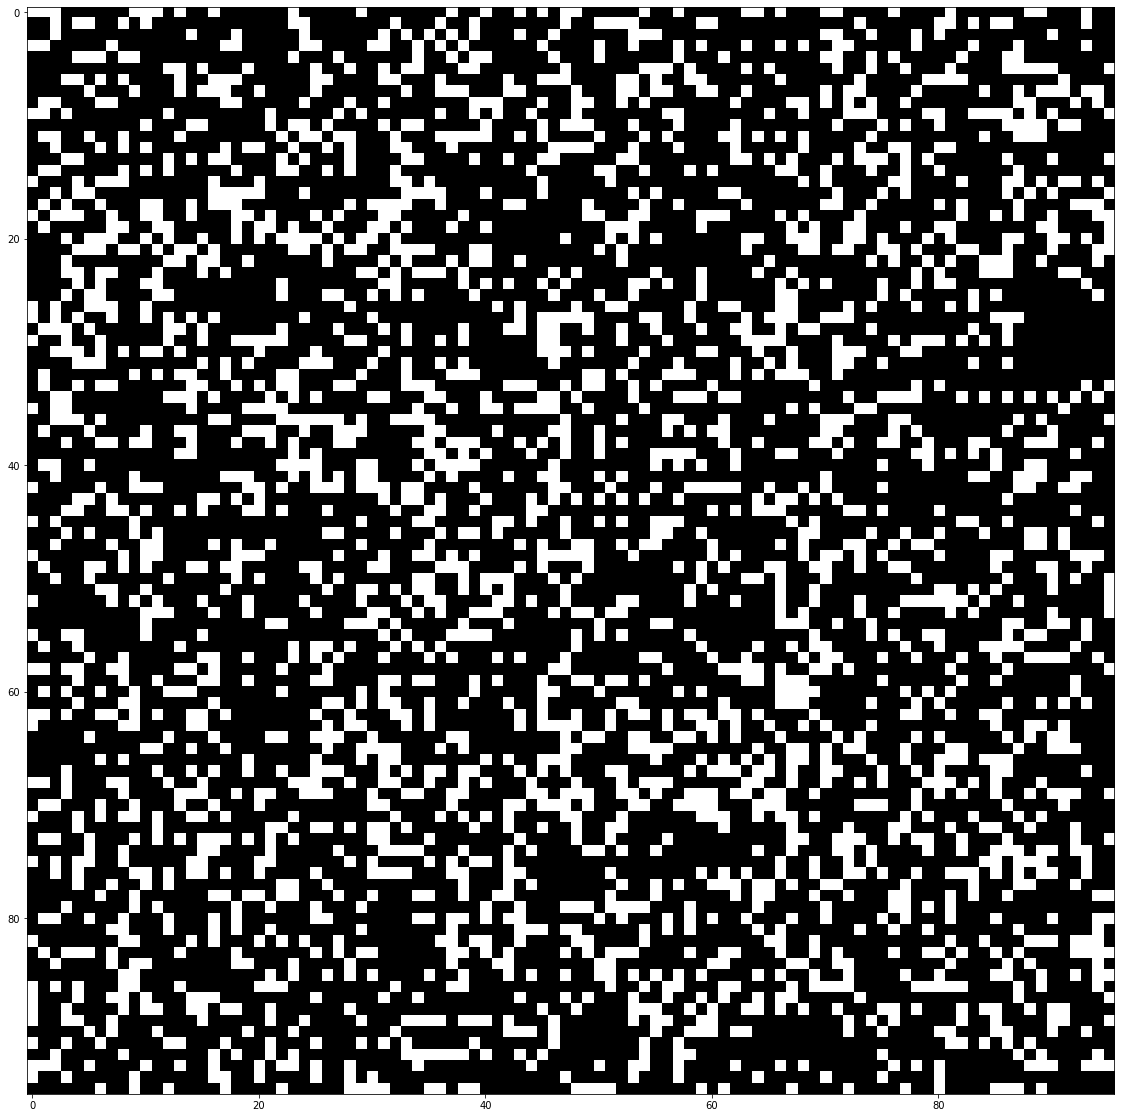

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.imshow(arr2, cmap='gray')

In [14]:
sea_monster = """\
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """
sea_monster = sea_monster.replace(' ', '0')
sea_monster = sea_monster.replace('#', '1')
mon_list = list()
for l in sea_monster.splitlines():
    mon_list.append([int(x) for x in l])
mon_list

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]]

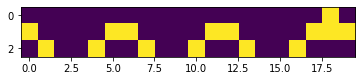

In [15]:
mon_arr = np.array(mon_list, dtype=np.uint8)
plt.imshow(mon_arr)

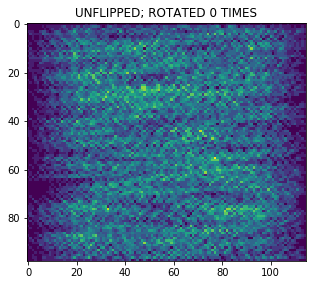

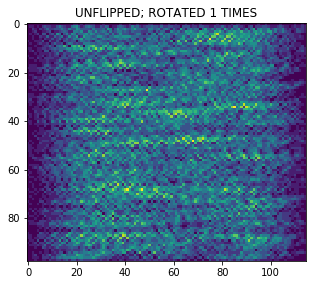

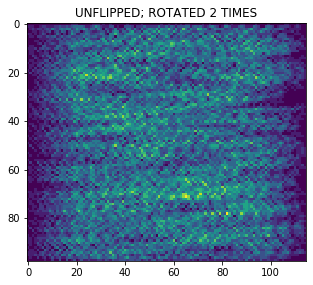

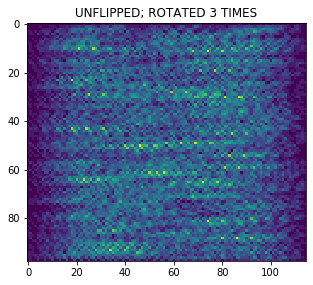

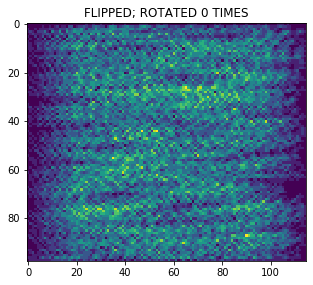

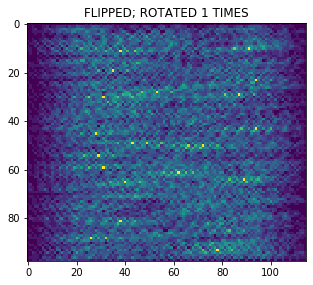

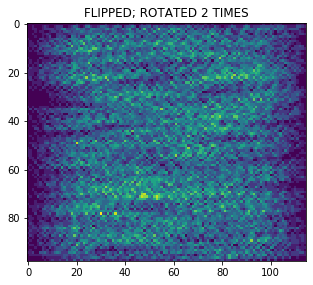

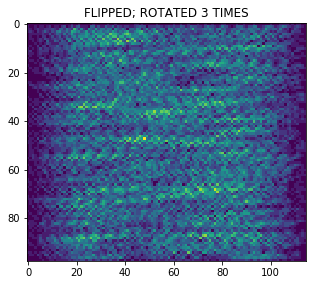

In [16]:
arr3 = arr2.copy()
state = 'UNFLIPPED'
for j in range(2):
    for i in range(4):
        rot = "ROTATED {} TIMES".format(i)
        corr = signal.correlate2d(mon_arr, np.rot90(arr3, i))
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        ax.set_title("{}; {}".format(state, rot))
        ax.imshow(corr)
    state = 'FLIPPED'
    arr3 = np.fliplr(arr2)

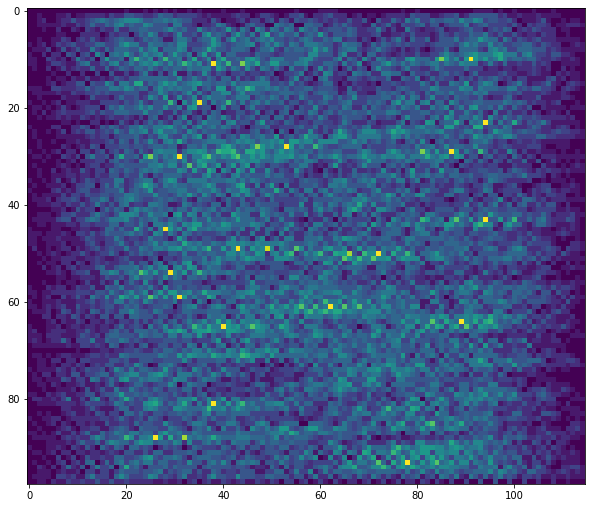

In [17]:
# The best cross-correlation with definitive sea-monster matches
# observable as solitary peaks in the image is "FLIPPED; ROTATE 1 TIMES".
# Transform our array accordingly:
# Flip L/R and rot90 1
arr4 = np.rot90(np.fliplr(arr2), 1)
corr = signal.correlate2d(mon_arr, arr4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(corr, cmap='viridis')

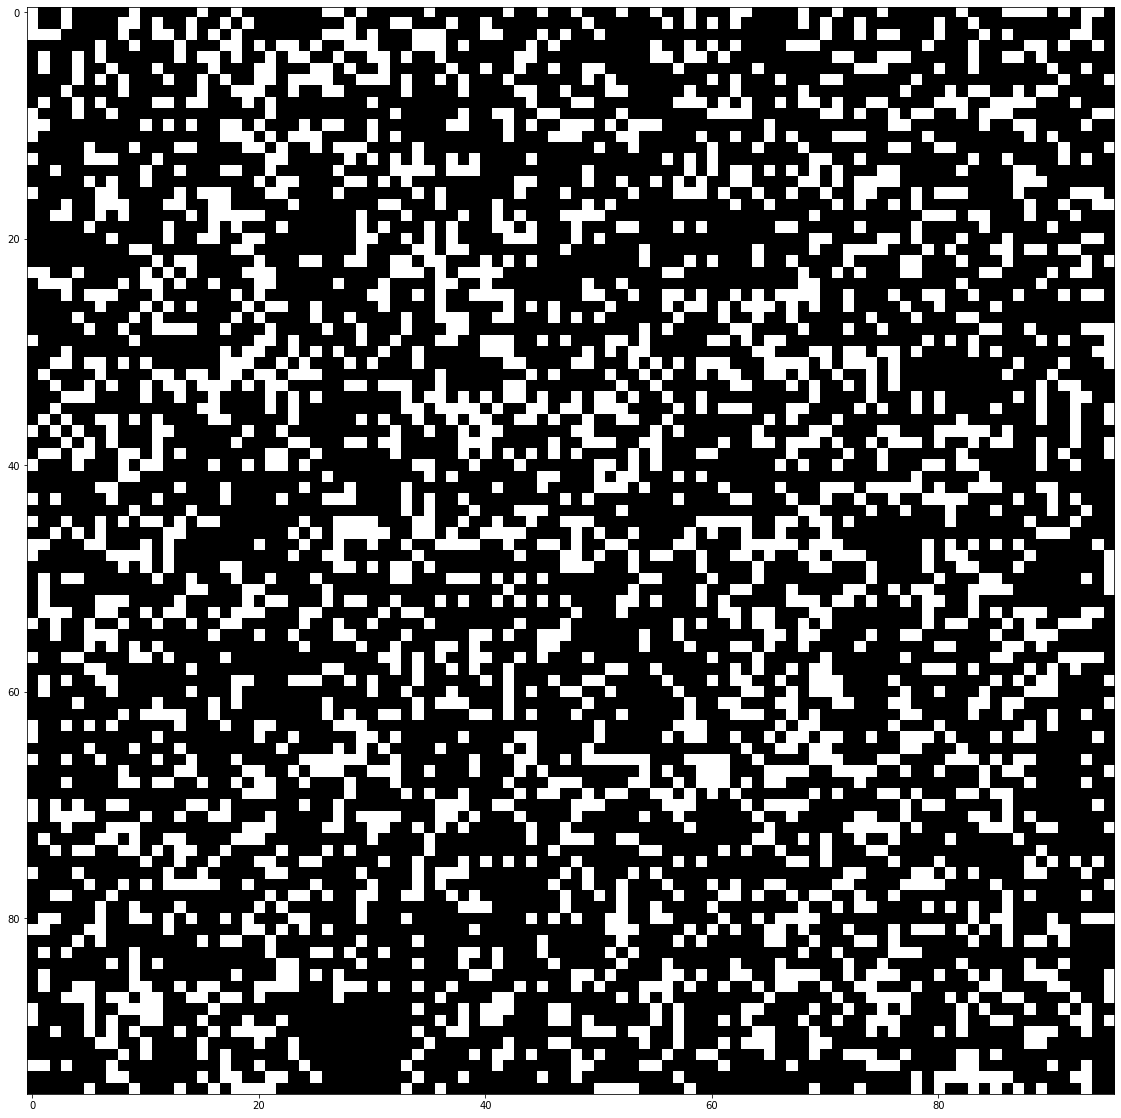

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.imshow(arr4, cmap='gray')

In [19]:
# Boxcar the seamonster through the array.
# Wherever all of his 1 bits overlap with 1 bits
# in the sea then we have a monster there.

In [20]:
ht, wd = arr4.shape
(ht, wd)

(96, 96)

In [21]:
mht, mwd = mon_arr.shape
(mht, mwd)

(3, 20)

In [22]:
arr5 = arr4.copy()
# Get indices for placing corner of the monster
iin = np.ndindex((ht-mht, wd-mwd))
for r, c in iin:
    subarr = arr5[r:r+mht, c:c+mwd]
    if np.all(mon_arr * subarr == mon_arr):
        # Highlight the sea monsters
        subarr += mon_arr

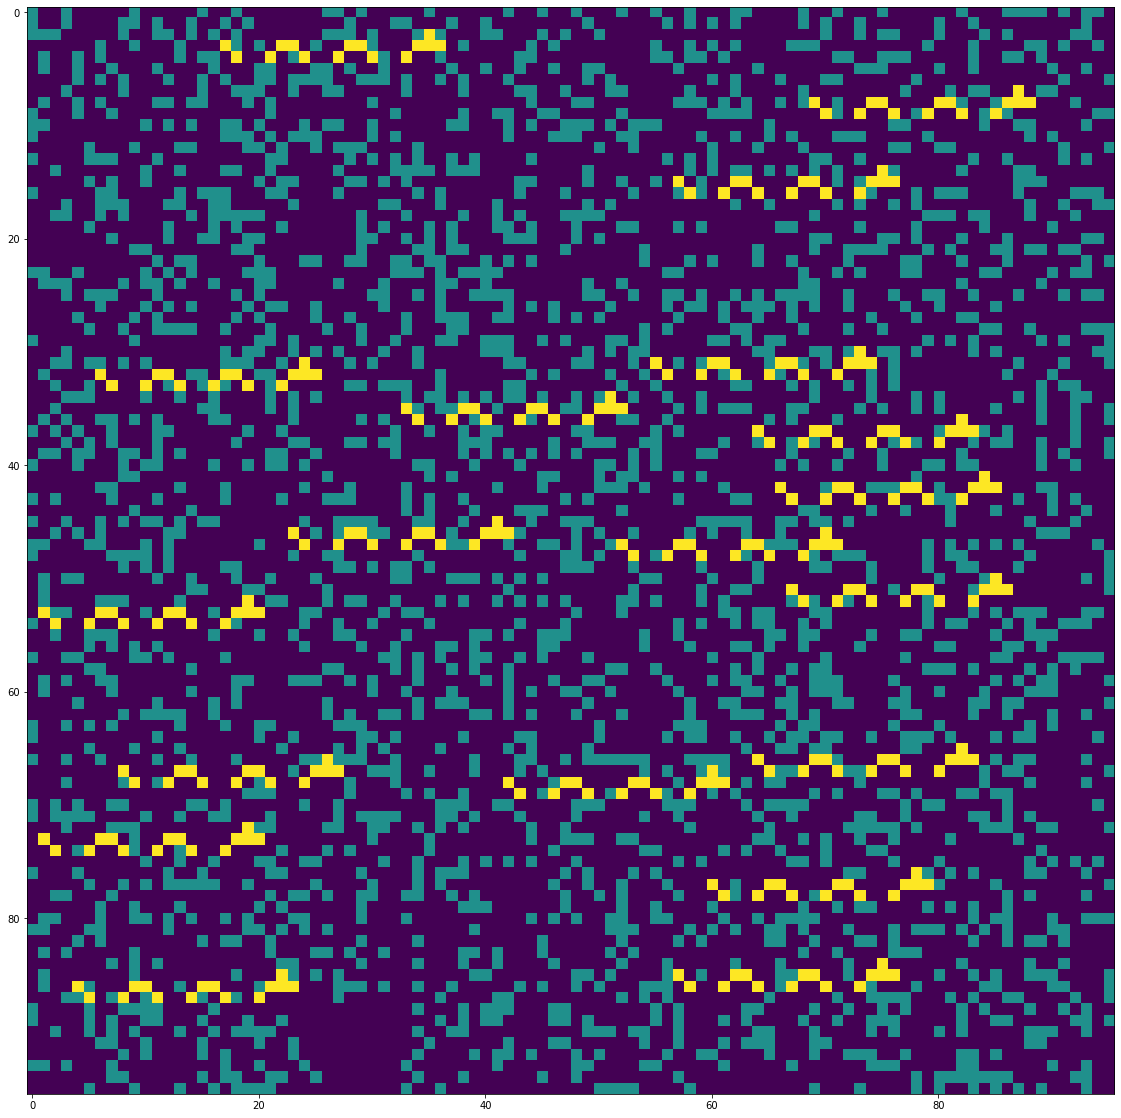

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.imshow(arr5, cmap='viridis')

In [2]:
# Wherever the array value is still one is "rough water"
# for us to count towards the solution
#Markdown("The amount of rough waters in the sea monster' habitat is "
#         "**{}**".format(np.sum(arr5 == 1)))